In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
from tqdm import tqdm
import random
import time
import copy
import itertools
import shutil
from sklearn.model_selection import train_test_split

import torchvision
from torchvision import transforms, models
from torchvision.transforms import ToTensor, Normalize, ToPILImage
from torchvision.transforms.functional import hflip, vflip, rotate, adjust_hue
import cv2
from skimage import io, transform
from skimage import io, transform
import albumentations as A
from albumentations import (HorizontalFlip, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torchvision.models.feature_extraction import create_feature_extractor
from torchsummary import summary

cudnn.benchmark = True

In [ ]:
# Key Parameters 
download_original= 0 # download the slide image and masks from google bucket
BATCH_SIZE = 2

# original width and height of image (standardized in all images)
width, height = 256, 256

In [ ]:
# download the image the google bucket that I set up 
# credit: http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html
if download_original == 1: 
    image_url = 'https://storage.googleapis.com/acv_project/floro_train.zip'
    !curl -O $image_url
    !unzip floro_train -d fluo
    !rm floro_train.zip
    image_url = 'https://storage.googleapis.com/acv_project/floro_test.zip'
    !curl -O $image_url
    !unzip floro_test -d fluo
    !rm floro_test.zip

In [ ]:
class FluoroDataset(torch.utils.data.Dataset):
    def __init__(self, img_dir, transforms = None):
        self.transforms = Compose([A.RandomRotate90(p=0.5), A.HorizontalFlip(p=0.5), A.VerticalFlip(p=0.5)]) 

        # corresponding files have the same file names
        self.file_HR_dir = img_dir + '/target'
        self.file_HR = os.listdir(img_dir + '/target')
        self.file_SR_dir = img_dir + '/input'
    
    def __len__(self):
        return len(self.file_HR)
    
    def __getitem__(self,idx):
        try: 

            # read images and masks from directory.
            # Masks represent high-resolution images (targets) for low-res images.                
            img = io.imread(os.path.join(self.file_SR_dir, self.file_HR[idx])).astype('float32')
            size = 256
            img = transform.resize(img,(size,size))
            img = cv2.normalize(img, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
                    
            mask = io.imread(os.path.join(self.file_HR_dir, self.file_HR[idx])).astype('float32')
            mask = transform.resize(mask,(size,size))
            mask = cv2.normalize(mask, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)

            augmented = self.transforms(image=img, mask=mask) # data augmentation
            img = augmented['image']
            mask = augmented['mask']
                
            # convert everything into a torch.Tensor
            mask = torch.as_tensor(mask, dtype=torch.float32)
            img = torch.as_tensor(img, dtype=torch.float32)

            img = img.unsqueeze(0)
            mask = mask.unsqueeze(0)
  
            return {"file_name": self.file_HR[idx], "img": img, "mask": mask}
        
        except Exception as exc:
            return None

def collate_fn(batch):
    # Filter failed images first
    batch = list(filter(lambda x: x is not None, batch))
    
    # Now collate into mini-batches
    img = torch.stack([b["img"] for b in batch]) 
    mask = torch.stack([b["mask"] for b in batch])
    return mask, img

image_datasets = {x: FluoroDataset(os.path.join('./fluo', x)) for x in ['train', 'test']}
# implement custom image_dataset and wrap it with the dataloader
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE, drop_last=True,
                                              shuffle=True, num_workers=0, collate_fn = collate_fn)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
print('size of dataset', dataset_sizes)

size of dataset {'train': 48, 'test': 5}


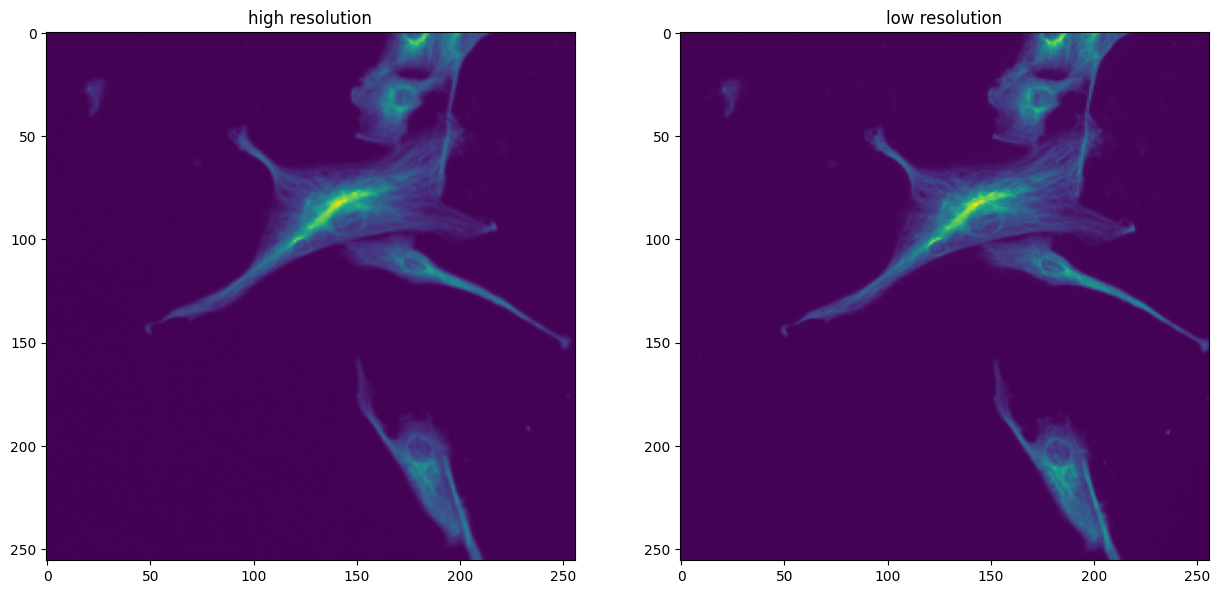

In [ ]:
# sample output
sample = next(iter(dataloaders['train']))
lr = sample[0][0]
sr = sample[1][0]
fig, axs = plt.subplots(1, 2, figsize=(15, 10))

# Display the LR and HR images using matplotlib
axs[0].imshow(ToPILImage()(sr))
axs[0].set_title('high resolution')
axs[1].imshow(ToPILImage()(lr))
axs[1].set_title('low resolution')
plt.show()

In [ ]:
# SRGAN Generator 
# adapted from https://github.com/Lornatang/SRGAN-PyTorch/blob/main/model.py

def ResidualConvBlock(channels):
    return nn.Sequential(nn.Conv2d(in_channels = channels, 
                                   out_channels = channels, 
                                   kernel_size = (3, 3), 
                                   stride = (1, 1), 
                                   padding = (1, 1), 
                                   bias=False),
                         nn.BatchNorm2d(channels),
                         nn.PReLU(), # great for mapping low-resolution images to high-resolution images
                         nn.Conv2d(channels, channels, (3, 3), (1, 1), (1, 1), bias=False),
                         nn.BatchNorm2d(channels), 
                         nn.Dropout(p=0.05))

# only zoom in by 2x each time
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        in_channels = 1
        out_channels = 1
        channels = 64 # this is the intermediate channels in the network

        # low frequency information extraction layer
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, channels, (9, 9), (1, 1), (4, 4)),
            nn.PReLU())

        # 5 Residual Blocks (note that there will be an element wise sum)
        self.rcb1 = ResidualConvBlock(channels)
        self.rcb2 = ResidualConvBlock(channels)
        self.rcb3 = ResidualConvBlock(channels) # reduced to prevent overfitting


        # high-frequency information linear fusion layer
        self.conv2 = nn.Sequential(nn.Conv2d(in_channels = channels, 
                                             out_channels = channels, 
                                             kernel_size = (3, 3), 
                                             stride = (1, 1), 
                                             padding = (1, 1), 
                                             bias=False),
                                   nn.BatchNorm2d(channels))

        # zoom block (we will only be zooming up by factor 2 each time)
        self.ub1 = nn.Sequential(nn.Conv2d(in_channels = channels,
                                          out_channels = channels * 4,
                                          kernel_size = (3, 3), 
                                          stride = (1, 1), 
                                          padding = (1, 1)),
                                nn.PixelShuffle(2),
                                nn.PReLU(), 
                                nn.AvgPool2d(2)) # note the addition of the average pooling layer
        self.ub2 = nn.Sequential(nn.Conv2d(in_channels = channels,
                                          out_channels = channels * 4,
                                          kernel_size = (3, 3), 
                                          stride = (1, 1), 
                                          padding = (1, 1)),
                                nn.PixelShuffle(2),
                                nn.PReLU(), 
                                nn.AvgPool2d(2)) # note the addition of the average pooling layer

        # reconstruction block
        self.conv3 = nn.Conv2d(in_channels = channels, 
                               out_channels = out_channels, 
                               kernel_size = (9, 9), 
                               stride = (1, 1), 
                               padding = (4, 4)) # retains the dimension of the output

    def forward(self, x):
        out1 = self.conv1(x)
        rcb1 = self.rcb1(out1)
        rcb2 = self.rcb2(torch.add(out1, rcb1)) # included the skip connections
        out2 = self.rcb3(torch.add(rcb1, rcb2))
        out2 = self.conv2(out2)
        out = torch.add(out1, out2)
        out = self.ub1(out)
        out = self.ub2(out)
        out = self.conv3(out)
        return out

# unit test
generator = Generator()
img = next(iter(dataloaders['train']))
lr = img[0]
gen_sr = generator(lr)[0]
sr = img[1]

output = generator(lr)
print(output.shape)

torch.Size([2, 1, 256, 256])


In [ ]:
def DiscriminatorConvBlock(in_channels, out_channels): 
    return nn.Sequential(nn.Conv2d(in_channels = in_channels, 
                                   out_channels = in_channels, 
                                   kernel_size = (3, 3), 
                                   stride = (2, 2), 
                                   padding = (1, 1), 
                                   bias=False),
                         nn.BatchNorm2d(in_channels),
                         nn.LeakyReLU(0.2, True),
                         nn.Conv2d(in_channels = in_channels, 
                                   out_channels = out_channels, 
                                   kernel_size = (3, 3), 
                                   stride = (2, 2), 
                                   padding = (1, 1), 
                                   bias=False),
                         nn.BatchNorm2d(out_channels),
                         nn.LeakyReLU(0.2, True), 
                         nn.Dropout(p=0.05))

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # input shape (2) x 256 x 256
        self.conv1 = nn.Sequential(nn.Conv2d(2, 64, (3, 3), (1, 1), (1, 1), bias=True),
                                   nn.LeakyReLU(0.2, True))
        self.conv2 = DiscriminatorConvBlock(64, 128)
        self.conv3 = DiscriminatorConvBlock(128, 256)
        self.conv4 = DiscriminatorConvBlock(256, 512)
        self.conv5 = DiscriminatorConvBlock(512, 1024) 
        # input shape (1024) * 1 * 1
        self.classifier = nn.Sequential(nn.Linear(1024, 1024),
                                        nn.LeakyReLU(0.2, True),
                                        nn.Dropout(p=0.05),
                                        nn.Linear(1024, 1), 
                                        nn.Sigmoid()) # for BCE loss

    def forward(self, lr, sr):
        x = torch.cat((lr, sr), 1) # need both the input and the output to distinguish
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)   
        out = torch.flatten(out, 1)
        out = self.classifier(out)
        return out

# unit test
discriminator = Discriminator()
img = next(iter(dataloaders['train']))
lr = img[0]
gen_sr = generator(lr)[0]
sr = img[1]
output = discriminator(lr, sr)
print(output.shape)

torch.Size([2, 1])


In [ ]:
# reference: https://towardsdatascience.com/light-on-math-machine-learning-intuitive-guide-to-neural-style-transfer-ef88e46697ee
# content loss (loss based on the perceptual quality of the generated SR image as compared to the perceptual quality of the original HR image)
class ContentLoss(nn.Module):
    def __init__(self):
        super(ContentLoss, self).__init__()

        # load the VGG19 model trained on the ImageNet dataset
        # vgg: features (36 nodes) -> avg pool -> classifier

        model = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1)

        # standard basic (this is hardcoded to prevent modifications)
        self.feature_model_extractor_node = "features.35" # extract the thirty-sixth layer output in the VGG19 model as the content loss

        # feature extractor
        self.feature_extractor = create_feature_extractor(model, [self.feature_model_extractor_node])

        # set to validation mode
        self.feature_extractor.eval()
 
        # Freeze model parameters.
        for model_parameters in self.feature_extractor.parameters():
            model_parameters.requires_grad = False

        self.mse_loss = nn.MSELoss()

    def forward(self, out_image, target_image):
        # put feature extractor to the same device
        if out_image.is_cuda: 
            self.feature_extractor.cuda()
        # standardized operations
        out_feature = self.feature_extractor(out_image)[self.feature_model_extractor_node]
        target_feature = self.feature_extractor(target_image)[self.feature_model_extractor_node]
        # find the feature map mse between the two images
        loss = self.mse_loss(target_feature, out_feature)
        return loss

# reference: https://towardsdatascience.com/super-resolution-a-basic-study-e01af1449e13
# total variation loss (supress the noise in the generated image)
class TVLoss(nn.Module): 
    def __init__(self):
        super(TVLoss, self).__init__()

    def forward(self, x):
        batch_size = BATCH_SIZE
        h_x = height
        w_x = width
        h_tv = torch.pow((x[:, :, 1:, :] - x[:, :, :h_x - 1, :]), 2).sum()
        w_tv = torch.pow((x[:, :, :, 1:] - x[:, :, :, :w_x - 1]), 2).sum()
        return (h_tv + w_tv)/(w_x * h_x * 3 * batch_size)

# generator loss
# reference: https://github.com/leftthomas/SRGAN
class GeneratorLoss(nn.Module):
    def __init__(self):
        super(GeneratorLoss, self).__init__()
        # Load the VGG19 model trained on the ImageNet dataset.
        self.content_loss = ContentLoss()
        self.tv_loss = TVLoss()
        self.pixel_loss = nn.MSELoss()

    def forward(self, out_labels, out_images, target_images):
        adversarial_loss = torch.mean(1 - out_labels)
        content_loss = self.content_loss(torch.cat((out_images, out_images, out_images), 1), 
                                         torch.cat((target_images, target_images, target_images), 1))
        tv_loss = self.tv_loss(out_images)
        pixel_loss = self.pixel_loss(out_images, target_images)
        # print('adversarial_loss', adversarial_loss)
        # print('content loss:', content_loss)
        # print('total variation loss:', tv_loss)
        # print('pixel_loss:', pixel_loss)
        
        return 0.01 * adversarial_loss + content_loss +  tv_loss + pixel_loss

# unit test
img = next(iter(dataloaders['train']))
sr1 = img[1]
img = next(iter(dataloaders['train']))
sr2 = img[1]
gl = GeneratorLoss()
print('generator loss:', gl(torch.ones(BATCH_SIZE), sr1, sr2))


generator loss: tensor(0.0920)


In [ ]:
# model training
# create a place to save memory
model_path = './model'
if not os.path.exists(model_path):
    os.mkdir(model_path) # save all models to this path

In [ ]:
# train generator network first (warm start)

# parameters for training the generator network (round 1)
device = 'cuda:0'
model_g = Generator().to(device)
optimizer_g = optim.Adam(model_g.parameters(), lr=0.001) 
scheduler_g = lr_scheduler.StepLR(optimizer_g, step_size = 8, gamma = 0.5)
criterion_g = GeneratorLoss()
num_epochs = 10 # we just want to warm start the generator here

In [ ]:
# train the generator Model
train_loss_list = []
val_loss_list = []
best_loss = 100.0

for epoch in range(num_epochs):
    # training step
    model_g.train()
    torch.set_grad_enabled(True)
    train_running_loss = 0
    for lr, sr in tqdm(dataloaders['train']):
        lr = lr.to(device)
        sr = sr.to(device)
        optimizer_g.zero_grad()
        outputs = model_g(lr)
        loss = criterion_g(torch.ones(output.shape, device = device), outputs, sr) # adverserial loss is 0
        loss.backward()
        optimizer_g.step()        
        train_running_loss += loss.item()
    scheduler_g.step()
    train_loss = train_running_loss * BATCH_SIZE/dataset_sizes['train']
    train_loss_list.append(train_loss)

    # validation step
    model_g.eval()
    torch.set_grad_enabled(False)
    # visualize how the mask prediction changes over time

    val_running_loss = 0
    for lr, sr in dataloaders['test']:
        lr = lr.to(device)
        sr = sr.to(device)
        outputs = model_g(lr)
        loss = criterion_g(torch.ones(output.shape, device = device), outputs, sr) # adverserial loss is 0
        val_running_loss += loss.item()
    val_loss = val_running_loss * BATCH_SIZE/dataset_sizes['test'] 
    val_loss_list.append(val_loss)

    # update the best model
    if val_loss < best_loss: 
        best_loss = val_loss
        torch.save(model_g.state_dict(), './model/generator')

    print(f'epoch: {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.8f}, Test Loss: {val_loss:.8f}')

100%|██████████| 24/24 [00:15<00:00,  1.57it/s]


epoch: 1/10, Train Loss: 0.07713818, Test Loss: 0.05645990


100%|██████████| 24/24 [00:11<00:00,  2.08it/s]


epoch: 2/10, Train Loss: 0.03909090, Test Loss: 0.03961768


100%|██████████| 24/24 [00:11<00:00,  2.02it/s]


epoch: 3/10, Train Loss: 0.03535770, Test Loss: 0.01210627


100%|██████████| 24/24 [00:11<00:00,  2.08it/s]


epoch: 4/10, Train Loss: 0.02779945, Test Loss: 0.02373375


100%|██████████| 24/24 [00:11<00:00,  2.11it/s]


epoch: 5/10, Train Loss: 0.02729281, Test Loss: 0.01823043


100%|██████████| 24/24 [00:11<00:00,  2.08it/s]


epoch: 6/10, Train Loss: 0.02469430, Test Loss: 0.01906823


100%|██████████| 24/24 [00:11<00:00,  2.09it/s]


epoch: 7/10, Train Loss: 0.03198801, Test Loss: 0.02263202


100%|██████████| 24/24 [00:11<00:00,  2.10it/s]


epoch: 8/10, Train Loss: 0.02675646, Test Loss: 0.01650772


100%|██████████| 24/24 [00:11<00:00,  2.11it/s]


epoch: 9/10, Train Loss: 0.01978577, Test Loss: 0.01129886


100%|██████████| 24/24 [00:11<00:00,  2.11it/s]


epoch: 10/10, Train Loss: 0.01906228, Test Loss: 0.01411813


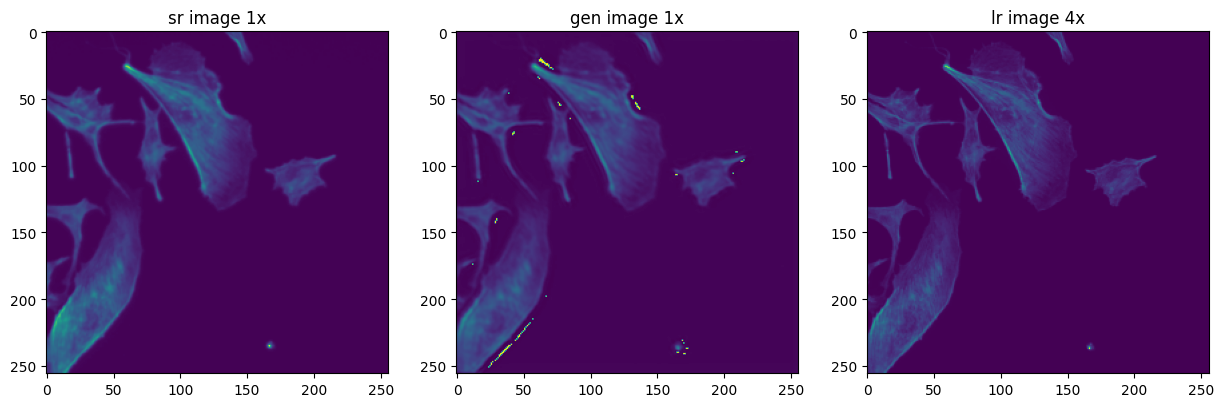

In [ ]:
# unit test
# sample output from pretrained generator
model_g.to('cpu')
img = next(iter(dataloaders['test']))
lr = img[0]
gen_sr = model_g(lr)[0]
lr = lr[0]
sr = img[1][0]

fig, axs = plt.subplots(1, 3, figsize=(15, 10))

# Display the LR and HR images using matplotlib
axs[0].imshow(ToPILImage()(sr))
axs[0].set_title('sr image 1x')
axs[1].imshow(ToPILImage()(gen_sr))
axs[1].set_title('gen image 1x')
axs[2].imshow(ToPILImage()(lr))
axs[2].set_title('lr image 4x')
plt.show()

In [ ]:
# parameters for training the discriminator network
model_g.load_state_dict(torch.load('./model/generator'))
model_g.to(device)
model_d = Discriminator().to(device)
optimizer_d = optim.Adam(model_d.parameters(), lr=0.01)
criterion_d = nn.BCELoss()
num_epochs = 5 # warm start so does not need that many

In [ ]:
# warm start the discriminator model (4x -> 1x)
# note that we are simplifying the loss function for the discriminator
discriminator_loss_list = []
discriminator_val_loss_list = []
best_loss = 100.0

for epoch in range(num_epochs):
    # train step
    running_loss_d = 0
    running_loss_g = 0
    model_d.train()
    model_g.train()
    torch.set_grad_enabled(True)
    for lr, sr in tqdm(dataloaders['train']):
        lr = lr.to(device)
        sr = sr.to(device)
        # log(D(x))
        optimizer_d.zero_grad()
        output = model_d(lr, sr)
        loss_d_real = criterion_d(output, torch.ones(output.shape, device = device))
        loss_d_real.backward()
        # log(1 - D(G(z)))
        fake_sr = model_g(lr)
        output = model_d(lr, fake_sr)
        loss_d_fake = criterion_d(output, torch.zeros(output.shape, device = device))
        loss_d_fake.backward(retain_graph=True)
        loss_d = loss_d_real + loss_d_fake
        optimizer_d.step()
        running_loss_d += loss_d.item()
    discriminator_loss = running_loss_d/dataset_sizes['train']
    discriminator_loss_list.append(discriminator_loss)

    # validation step
    model_d.eval()
    val_running_loss_d = 0
    torch.set_grad_enabled(False)
    for lr, sr in dataloaders['test']:
        lr = lr.to(device)
        sr = sr.to(device)
        # log(D(x))
        output = model_d(lr, sr)
        loss_d_real = criterion_d(output, torch.ones(output.shape, device = device))
        # log(1 - D(G(z)))
        fake_sr = model_g(lr)
        output = model_d(lr, fake_sr)
        loss_d_fake = criterion_d(output, torch.zeros(output.shape, device = device))
        loss_d = loss_d_real + loss_d_fake
        val_running_loss_d += loss_d.item()
    val_loss = val_running_loss_d/dataset_sizes['test']
    discriminator_val_loss_list.append(val_loss)
    # update the best model
    if val_loss < best_loss: 
        # save the weights
        best_loss = val_loss
        torch.save(model_d.state_dict(), './model/discriminator')
    # print the progress to determine if the progress has stagnated
    print(f'epoch: {epoch+1}/{num_epochs}, Discriminator Loss: {discriminator_loss:.4f}, Discriminator Validation Loss: {val_loss:.8f}')

100%|██████████| 24/24 [00:12<00:00,  1.90it/s]


epoch: 1/5, Discriminator Loss: 2.3554, Discriminator Validation Loss: 6.95406504


100%|██████████| 24/24 [00:11<00:00,  2.15it/s]


epoch: 2/5, Discriminator Loss: 1.4032, Discriminator Validation Loss: 1.42550383


100%|██████████| 24/24 [00:11<00:00,  2.11it/s]


epoch: 3/5, Discriminator Loss: 1.2189, Discriminator Validation Loss: 1.03043013


100%|██████████| 24/24 [00:11<00:00,  2.13it/s]


epoch: 4/5, Discriminator Loss: 0.9331, Discriminator Validation Loss: 0.69658544


100%|██████████| 24/24 [00:11<00:00,  2.12it/s]


epoch: 5/5, Discriminator Loss: 0.7951, Discriminator Validation Loss: 0.91089859


In [ ]:
# load the pretrained generator and discriminator
model_g.load_state_dict(torch.load('./model/generator'))
model_g.to(device)
model_d.load_state_dict(torch.load('./model/discriminator'))
model_d.to(device)

# set the number of epochs
num_epochs = 50

# train the SRGAN model (4x -> 1x)
discriminator_loss_list = []
generator_loss_list = []
generator_val_loss_list = []
best_loss = 100.0

for epoch in range(num_epochs):
    # train step
    running_loss_d = 0
    running_loss_g = 0
    model_d.train()
    model_g.train()
    torch.set_grad_enabled(True)
    for lr, sr in tqdm(dataloaders['train']):
        lr = lr.to(device)
        sr = sr.to(device)
        ############################
        # (1) update D network: maximize log(D(x))+log(1-D(G(z)))
        ###########################
        optimizer_d.zero_grad()
        output = model_d(lr, sr)
        loss_d_real = criterion_d(output, torch.ones(output.shape, device = device))
        loss_d_real.backward()
        # log(1 - D(G(z)))
        fake_sr = model_g(lr)
        output = model_d(lr, fake_sr)
        loss_d_fake = criterion_d(output, torch.zeros(output.shape, device = device))
        loss_d_fake.backward(retain_graph=True)
        loss_d = loss_d_real + loss_d_fake
        optimizer_d.step()
        running_loss_d += loss_d.item()
        ############################
        # (2) update G network: minimize 1-D(G(z)) + Content Loss + TV Loss
        ###########################
        optimizer_g.zero_grad()
        # note that fake labels are real for generator cost
        loss_g = criterion_g(out_labels = output, out_images = fake_sr, target_images = sr) 
        loss_g.backward()
        optimizer_g.step()
        running_loss_g += loss_g.item()
    discriminator_loss = running_loss_d/dataset_sizes['train']
    discriminator_loss_list.append(discriminator_loss)
    generator_loss = running_loss_g/dataset_sizes['train']
    generator_loss_list.append(generator_loss)

    # validation step
    model_g.eval()
    val_running_loss = 0
    torch.set_grad_enabled(False)
    for lr, sr in dataloaders['test']:
        lr = lr.to(device)
        sr = sr.to(device)
        fake_sr = model_g(lr)
        output = model_d(lr, fake_sr) 
        loss = criterion_g(out_labels = output, out_images = fake_sr, target_images = sr) 
        val_running_loss += loss.item() 
    val_loss = val_running_loss/dataset_sizes['test']
    generator_val_loss_list.append(val_loss)
    # update the best model
    if val_loss < best_loss: 
        # save the weights
        best_loss = val_loss
        torch.save(model_g.state_dict(), './model/gan_generator')
        torch.save(model_d.state_dict(), './model/gan_discriminator')

    # print the progress to determine if the progress has stagnated
    print(f'epoch: {epoch+1}/{num_epochs}, Generator Loss: {generator_loss:.4f}, Discriminator Loss: {discriminator_loss:.4f}, Generator Validation Loss: {val_loss:.8f}')

100%|██████████| 24/24 [00:12<00:00,  1.96it/s]


epoch: 1/50, Generator Loss: 0.0120, Discriminator Loss: 0.7506, Generator Validation Loss: 0.01010790


100%|██████████| 24/24 [00:12<00:00,  1.96it/s]


epoch: 2/50, Generator Loss: 0.0132, Discriminator Loss: 0.7708, Generator Validation Loss: 0.00918547


100%|██████████| 24/24 [00:12<00:00,  1.96it/s]


epoch: 3/50, Generator Loss: 0.0125, Discriminator Loss: 0.7648, Generator Validation Loss: 0.00894394


100%|██████████| 24/24 [00:12<00:00,  1.96it/s]


epoch: 4/50, Generator Loss: 0.0113, Discriminator Loss: 0.7822, Generator Validation Loss: 0.00466899


100%|██████████| 24/24 [00:12<00:00,  1.94it/s]


epoch: 5/50, Generator Loss: 0.0102, Discriminator Loss: 0.7671, Generator Validation Loss: 0.00859111


100%|██████████| 24/24 [00:12<00:00,  1.94it/s]


epoch: 6/50, Generator Loss: 0.0105, Discriminator Loss: 0.7566, Generator Validation Loss: 0.00985669


100%|██████████| 24/24 [00:12<00:00,  1.89it/s]


epoch: 7/50, Generator Loss: 0.0130, Discriminator Loss: 0.7850, Generator Validation Loss: 0.00469010


100%|██████████| 24/24 [00:12<00:00,  1.94it/s]


epoch: 8/50, Generator Loss: 0.0110, Discriminator Loss: 0.9987, Generator Validation Loss: 0.00828888


100%|██████████| 24/24 [00:12<00:00,  1.95it/s]


epoch: 9/50, Generator Loss: 0.0110, Discriminator Loss: 0.9036, Generator Validation Loss: 0.00855382


100%|██████████| 24/24 [00:12<00:00,  1.94it/s]


epoch: 10/50, Generator Loss: 0.0109, Discriminator Loss: 0.7788, Generator Validation Loss: 0.00744130


100%|██████████| 24/24 [00:12<00:00,  1.95it/s]


epoch: 11/50, Generator Loss: 0.0104, Discriminator Loss: 0.7679, Generator Validation Loss: 0.00878451


100%|██████████| 24/24 [00:12<00:00,  1.95it/s]


epoch: 12/50, Generator Loss: 0.0122, Discriminator Loss: 0.7981, Generator Validation Loss: 0.00550540


100%|██████████| 24/24 [00:12<00:00,  1.97it/s]


epoch: 13/50, Generator Loss: 0.0106, Discriminator Loss: 0.7609, Generator Validation Loss: 0.00916223


100%|██████████| 24/24 [00:12<00:00,  1.95it/s]


epoch: 14/50, Generator Loss: 0.0106, Discriminator Loss: 0.7666, Generator Validation Loss: 0.00718119


100%|██████████| 24/24 [00:12<00:00,  1.94it/s]


epoch: 15/50, Generator Loss: 0.0121, Discriminator Loss: 0.8051, Generator Validation Loss: 0.00465420


100%|██████████| 24/24 [00:12<00:00,  1.94it/s]


epoch: 16/50, Generator Loss: 0.0101, Discriminator Loss: 0.7521, Generator Validation Loss: 0.00813164


100%|██████████| 24/24 [00:12<00:00,  1.92it/s]


epoch: 17/50, Generator Loss: 0.0103, Discriminator Loss: 0.7746, Generator Validation Loss: 0.00882938


100%|██████████| 24/24 [00:12<00:00,  1.94it/s]


epoch: 18/50, Generator Loss: 0.0115, Discriminator Loss: 0.7231, Generator Validation Loss: 0.00961182


100%|██████████| 24/24 [00:12<00:00,  1.94it/s]


epoch: 19/50, Generator Loss: 0.0102, Discriminator Loss: 0.8841, Generator Validation Loss: 0.00734422


100%|██████████| 24/24 [00:12<00:00,  1.94it/s]


epoch: 20/50, Generator Loss: 0.0101, Discriminator Loss: 0.7334, Generator Validation Loss: 0.00873194


100%|██████████| 24/24 [00:12<00:00,  1.94it/s]


epoch: 21/50, Generator Loss: 0.0100, Discriminator Loss: 0.7168, Generator Validation Loss: 0.00867613


100%|██████████| 24/24 [00:12<00:00,  1.93it/s]


epoch: 22/50, Generator Loss: 0.0095, Discriminator Loss: 0.7123, Generator Validation Loss: 0.00806136


100%|██████████| 24/24 [00:13<00:00,  1.85it/s]


epoch: 23/50, Generator Loss: 0.0097, Discriminator Loss: 0.7075, Generator Validation Loss: 0.00848377


100%|██████████| 24/24 [00:12<00:00,  1.95it/s]


epoch: 24/50, Generator Loss: 0.0099, Discriminator Loss: 0.7591, Generator Validation Loss: 0.00881557


100%|██████████| 24/24 [00:12<00:00,  1.94it/s]


epoch: 25/50, Generator Loss: 0.0088, Discriminator Loss: 0.7702, Generator Validation Loss: 0.00769104


100%|██████████| 24/24 [00:12<00:00,  1.89it/s]


epoch: 26/50, Generator Loss: 0.0090, Discriminator Loss: 0.7402, Generator Validation Loss: 0.00907721


100%|██████████| 24/24 [00:12<00:00,  1.89it/s]


epoch: 27/50, Generator Loss: 0.0096, Discriminator Loss: 0.7095, Generator Validation Loss: 0.00459011


100%|██████████| 24/24 [00:12<00:00,  1.92it/s]


epoch: 28/50, Generator Loss: 0.0088, Discriminator Loss: 0.7267, Generator Validation Loss: 0.00464514


100%|██████████| 24/24 [00:12<00:00,  1.94it/s]


epoch: 29/50, Generator Loss: 0.0083, Discriminator Loss: 0.7480, Generator Validation Loss: 0.00782062


100%|██████████| 24/24 [00:12<00:00,  1.94it/s]


epoch: 30/50, Generator Loss: 0.0092, Discriminator Loss: 0.7704, Generator Validation Loss: 0.00887105


100%|██████████| 24/24 [00:12<00:00,  1.95it/s]


epoch: 31/50, Generator Loss: 0.0100, Discriminator Loss: 0.7242, Generator Validation Loss: 0.00810894


100%|██████████| 24/24 [00:12<00:00,  1.96it/s]


epoch: 32/50, Generator Loss: 0.0094, Discriminator Loss: 0.7063, Generator Validation Loss: 0.00811177


100%|██████████| 24/24 [00:12<00:00,  1.95it/s]


epoch: 33/50, Generator Loss: 0.0091, Discriminator Loss: 0.7041, Generator Validation Loss: 0.00469107


100%|██████████| 24/24 [00:12<00:00,  1.95it/s]


epoch: 34/50, Generator Loss: 0.0084, Discriminator Loss: 0.7232, Generator Validation Loss: 0.00455334


100%|██████████| 24/24 [00:12<00:00,  1.95it/s]


epoch: 35/50, Generator Loss: 0.0089, Discriminator Loss: 0.7242, Generator Validation Loss: 0.00493937


100%|██████████| 24/24 [00:12<00:00,  1.95it/s]


epoch: 36/50, Generator Loss: 0.0087, Discriminator Loss: 0.7145, Generator Validation Loss: 0.00791067


100%|██████████| 24/24 [00:12<00:00,  1.95it/s]


epoch: 37/50, Generator Loss: 0.0093, Discriminator Loss: 0.7177, Generator Validation Loss: 0.00842930


100%|██████████| 24/24 [00:12<00:00,  1.93it/s]


epoch: 38/50, Generator Loss: 0.0092, Discriminator Loss: 0.7090, Generator Validation Loss: 0.00752204


100%|██████████| 24/24 [00:12<00:00,  1.94it/s]


epoch: 39/50, Generator Loss: 0.0094, Discriminator Loss: 0.7227, Generator Validation Loss: 0.00875769


100%|██████████| 24/24 [00:12<00:00,  1.95it/s]


epoch: 40/50, Generator Loss: 0.0098, Discriminator Loss: 0.7158, Generator Validation Loss: 0.00944061


100%|██████████| 24/24 [00:12<00:00,  1.95it/s]


epoch: 41/50, Generator Loss: 0.0101, Discriminator Loss: 0.7011, Generator Validation Loss: 0.00793020


100%|██████████| 24/24 [00:12<00:00,  1.94it/s]


epoch: 42/50, Generator Loss: 0.0097, Discriminator Loss: 0.7406, Generator Validation Loss: 0.00517260


100%|██████████| 24/24 [00:12<00:00,  1.96it/s]


epoch: 43/50, Generator Loss: 0.0094, Discriminator Loss: 0.7089, Generator Validation Loss: 0.00761101


100%|██████████| 24/24 [00:12<00:00,  1.95it/s]


epoch: 44/50, Generator Loss: 0.0096, Discriminator Loss: 0.7158, Generator Validation Loss: 0.00720379


100%|██████████| 24/24 [00:12<00:00,  1.95it/s]


epoch: 45/50, Generator Loss: 0.0090, Discriminator Loss: 0.7184, Generator Validation Loss: 0.01024635


100%|██████████| 24/24 [00:12<00:00,  1.94it/s]


epoch: 46/50, Generator Loss: 0.0089, Discriminator Loss: 0.7119, Generator Validation Loss: 0.00773770


100%|██████████| 24/24 [00:12<00:00,  1.95it/s]


epoch: 47/50, Generator Loss: 0.0088, Discriminator Loss: 0.6999, Generator Validation Loss: 0.00751214


100%|██████████| 24/24 [00:12<00:00,  1.95it/s]


epoch: 48/50, Generator Loss: 0.0086, Discriminator Loss: 0.6906, Generator Validation Loss: 0.00782200


100%|██████████| 24/24 [00:12<00:00,  1.91it/s]


epoch: 49/50, Generator Loss: 0.0095, Discriminator Loss: 0.7314, Generator Validation Loss: 0.01006508


100%|██████████| 24/24 [00:12<00:00,  1.93it/s]


epoch: 50/50, Generator Loss: 0.0115, Discriminator Loss: 0.6919, Generator Validation Loss: 0.00872653


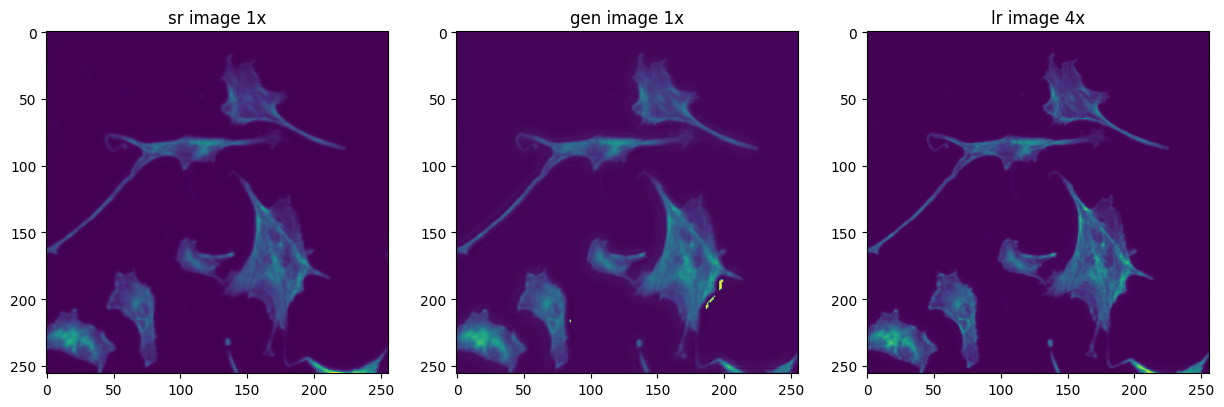

In [ ]:
# unit test
# sample output from pretrained generator
model_g.to('cpu')
img = next(iter(dataloaders['test']))
lr = img[0]
gen_sr = model_g(lr)[0]
lr = lr[0]
sr = img[1][0]

fig, axs = plt.subplots(1, 3, figsize=(15, 10))

# Display the LR and HR images using matplotlib
axs[0].imshow(ToPILImage()(sr))
axs[0].set_title('sr image 1x')
axs[1].imshow(ToPILImage()(gen_sr))
axs[1].set_title('gen image 1x')
axs[2].imshow(ToPILImage()(lr))
axs[2].set_title('lr image 4x')
plt.show()

In [ ]:
# adapted from xinwen model

# !pip install torchmetrics
# !pip install lpips
from torchmetrics import PeakSignalNoiseRatio
from torchmetrics import StructuralSimilarityIndexMeasure
import lpips
psnr = PeakSignalNoiseRatio().to(device)
ssim = StructuralSimilarityIndexMeasure().to(device)
loss_fn = lpips.LPIPS(net='alex').to(device)

# Evaluate model performance on test dataset (modified from xinyue model)
l1_loss = []
mse_loss = []
psnr_list = []
ssim_list = []
output_list = []
lpips_list = []
criterion1 = nn.L1Loss()
criterion2 = nn.MSELoss()
model_g.to(device)
model_g.eval()
with torch.no_grad():
    for lr, sr in dataloaders['test']:
        lr = lr.to(device)
        sr = sr.to(device)
        fake_sr = model_g(lr)
        # Compute L1 loss
        loss = criterion1(fake_sr, sr)
        l1_loss.append(loss.item())

        # Compute MSE loss
        loss2 = criterion2(fake_sr, sr)
        mse_loss.append(loss2.item())

        # Compute PSNR 
        psnr_value = psnr(fake_sr, sr)
        psnr_value = psnr_value.clone().cpu().detach().numpy()
        psnr_list.append(psnr_value)
        
        # Compute SSIM
        ssim_value = ssim(fake_sr, sr)
        ssim_value = ssim_value.clone().cpu().detach().numpy()
        ssim_list.append(ssim_value)

        # Compute LPIPS
        d = loss_fn.forward(fake_sr, sr).clone().cpu().detach().numpy()
        lpips_list.append(d)
        
print('l1_loss:', np.mean(l1_loss))
print('mse_loss', np.mean(mse_loss))
print('psnr:', np.mean(psnr_list))
print('lpips:', np.mean(lpips_list))
print('ssim:', np.mean(ssim_list))

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth
l1_loss: 0.04129911307245493
mse_loss 0.004712474066764116
psnr: 25.471146
lpips: 0.052593455
ssim: 0.60087717
